In [1]:
import os
# Enforces CPU-only execution of torch
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Configure environment to ensure single-threaded execution.
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"]= "1"
os.environ["OMP_NUM_THREADS"] = "1"

import torch
torch.set_num_threads(1)

from xtr.datasets import BEIR, BEIRDataset, LoTTE, LoTTEDataset
from xtr.config import XTRConfig, XTRModel, XTRScaNNIndexConfig, XTRBruteForceIndexConfig, XTRFAISSIndexConfig
from xtr.utils import xtr_tracker, canonical_index_name
from xtr.modeling.xtr import XTR

import json
from datetime import datetime

/future/u/scheerer/miniconda3/envs/xtr-eval/lib/python3.8/site-packages/beir/util.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [21]:
NUM_QUERIES = 5
DOCUMENT_TOP_K = 100
TOKEN_TOP_K = 40_000

In [3]:
dataset = LoTTEDataset(dataset=LoTTE.LIFESTYLE, datasplit="test")
index_config = XTRScaNNIndexConfig()
index_name = canonical_index_name(dataset=dataset, index_config=index_config)
config = XTRConfig(index_name=index_name, model=XTRModel.BASE_EN, index_config=index_config, override=False)

xtr = XTR(config=config, collection=dataset.collection, device=torch.device("cpu"))

#> Loading collection from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/test/collection.tsv ...
0M 
#> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/test/questions.search.tsv ...
#> Got 661 queries. All QIDs are unique.
Loading existing index from /future/u/scheerer/home/data/xtr-eval/indexes/LoTTE.LIFESTYLE.search.split=test.XTRIndexType.SCANN.


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 38:5: text format contains deprecated field "min_cluster_size"


In [4]:
from xtr.data.queries import Queries
queries_test = Queries.cast(list(map(lambda x: x[1], dataset.queries))[:NUM_QUERIES])

In [12]:
from xtr.utils.tracker import ExecutionTracker

groups = {
    "Candidate Generation": ["search_batched", "enumerate_scores"],
    "Aggregate Scores": ["get_did2scores", "add_ems", "get_final_score", "sort_scores"]
}

tracker = ExecutionTracker(name=index_name, steps=["Query Encoding", "search_batched", "enumerate_scores", "Estimate Missing Similarity",
                                                   "get_did2scores", "add_ems", "get_final_score", "sort_scores"])
rankings = xtr.retrieve_docs(queries_test, document_top_k=DOCUMENT_TOP_K, token_top_k=TOKEN_TOP_K, tracker=tracker)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.58s/it]


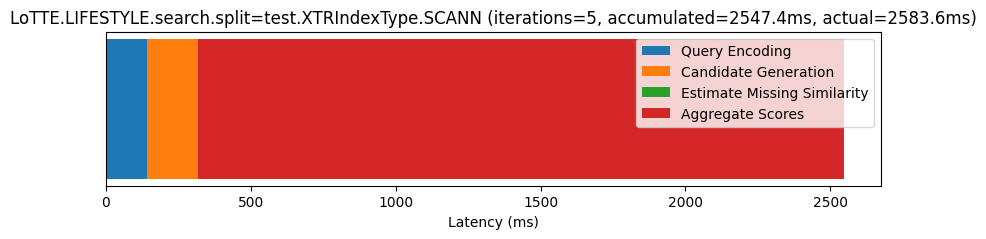

In [13]:
tracker.display_grouped(groups, detailed=False)

In [7]:
from xtr.modeling.xtr_opt import XTROpt

xtr_opt = XTROpt(config=config, collection=dataset.collection, device=torch.device("cpu"))

Loading existing index from /future/u/scheerer/home/data/xtr-eval/indexes/LoTTE.LIFESTYLE.search.split=test.XTRIndexType.SCANN.


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 38:5: text format contains deprecated field "min_cluster_size"
100%|████████████████████████████████████████████████████████████████████████████████████| 23713178/23713178 [01:34<00:00, 250692.36it/s]


In [14]:
tracker_opt = ExecutionTracker(name=index_name, steps=["Query Encoding", "search_batched", "enumerate_scores", "Estimate Missing Similarity",
                                                   "get_did2scores", "add_ems", "get_final_score", "sort_scores"])
rankings_opt = xtr_opt.retrieve_docs(queries_test, document_top_k=DOCUMENT_TOP_K, token_top_k=TOKEN_TOP_K, tracker=tracker_opt)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


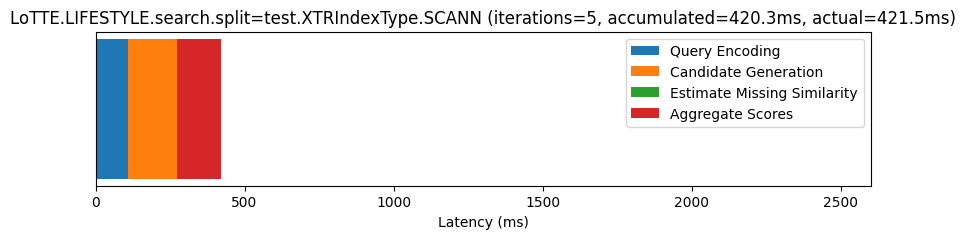

In [19]:
tracker_opt.display_grouped(groups, bound=2600, detailed=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]


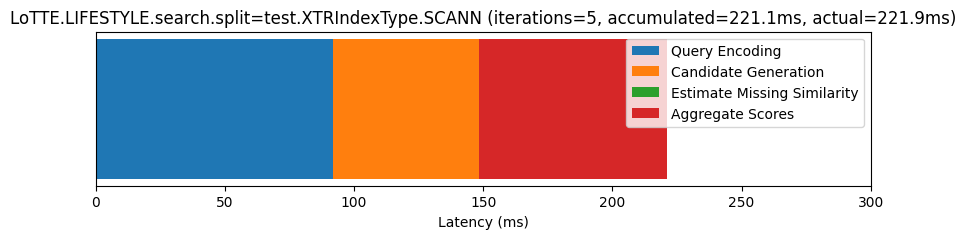

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


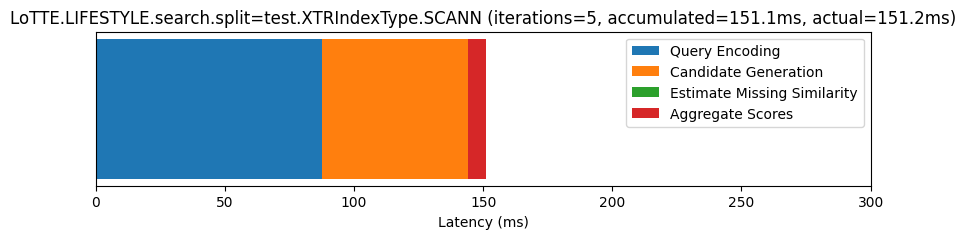

In [23]:
TOKEN_TOP_K = 1_000
tracker = ExecutionTracker(name=index_name, steps=["Query Encoding", "search_batched", "enumerate_scores", "Estimate Missing Similarity",
                                                   "get_did2scores", "add_ems", "get_final_score", "sort_scores"])
rankings = xtr.retrieve_docs(queries_test, document_top_k=DOCUMENT_TOP_K, token_top_k=TOKEN_TOP_K, tracker=tracker)
tracker.display_grouped(groups, bound=300, detailed=False)

tracker_opt = ExecutionTracker(name=index_name, steps=["Query Encoding", "search_batched", "enumerate_scores", "Estimate Missing Similarity",
                                                   "get_did2scores", "add_ems", "get_final_score", "sort_scores"])
rankings_opt = xtr_opt.retrieve_docs(queries_test, document_top_k=DOCUMENT_TOP_K, token_top_k=TOKEN_TOP_K, tracker=tracker_opt)
tracker_opt.display_grouped(groups, bound=300, detailed=False)